Kramer versus Kramer
---------------------------

Explain this

In [1]:
# random
from random import random

# math functions
from math import cos, sin, atan2
from math import radians

# load MDAnalysis library 
# to deal with GRO/XTC files
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis.dihedrals import Ramachandran

# arrays
import numpy as np

# machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Molecular Dynamics in *Anton 2*
--------------------------------------

Load trajectory files. Describe them. Form of the restrain!

In [2]:
# define path to structure files
PATHD = "../datasets/trajectories/"
FRAME = PATHD + "CLCec1_anton2_restrained_15us.gro"
TRAJ1 = PATHD + "CLCec1_anton2_restrained_15us.xtc"
TRAJ2 = PATHD + "CLCec1_anton2_unrestrain_15us.xtc"

# load traj files
rest = mda.Universe(FRAME,TRAJ1)
unrs = mda.Universe(FRAME,TRAJ2)

 I will avoid fitting (rot+trans) for now

In [3]:
# fitting
#ref = mda.Universe(FRAME)
#fit = align.AlignTraj(trj, ref, select="protein and name CA", in_memory=True)
#fit.run()

Ramachandran analysis
----------------------------

Let's compare both trajectories using a simple dihedral analysis, no fitting requiered

In [3]:
# select protein residues
restrained = rest.select_atoms("protein and resid 2-429")
unrestrain = unrs.select_atoms("protein and resid 2-429")

# quick calculation of phi and psi angles
R = Ramachandran(restrained).run()
U = Ramachandran(unrestrain).run()

plotting. 

1) get a reference using RESTful

2) use a better plotting program

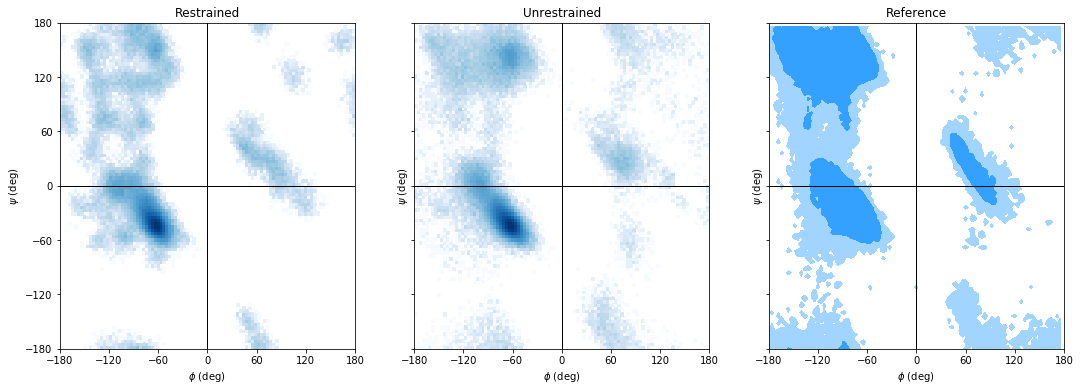

In [19]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')
axes[2].title.set_text('Reference')
    
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# plot backbone dihedral maps for all frames
axes[0].hist2d(r[:,0], r[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(u[:,0], u[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

# plot reference map which shows allowed and marginally allowed regions
U.plot(ax=axes[2], color='k', marker=".", alpha=0.0, ref=True)

plt.show()

<center>the <i>Unrestrained</i> is more flexible, as expected, but also more similar to the <i>Reference</i> map.
At least for me, in a qualitative way.</center>

dPCA+
--------

Let's compare the 2 trajectories!

In [57]:
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# convert to radians
ress = np.deg2rad(r)
unre = np.deg2rad(u)

# combine datasets
data = np.vstack((ress,unre))

In [22]:
# calculate angular mean
def circmean(angles):
    # transformation
    c = np.cos(angles)
    s = np.sin(angles)
    # average
    return atan2(np.average(s), np.average(c))

# minimum distance 
# between 2 angles
def dangle(x, y):
    # x is the target angle
    # y is the source or starting angle
    return atan2(sin(x-y), cos(x-y))

# wrap coordinates 
def wrap(angles, delta):
    circle = 2.*pi
    return (angles - delta) % circle - pi

# rotate angles
def rotate(angles, theta):
    # cartesian transform
    x = np.vstack((np.cos(angles), 
                   np.sin(angles)))
    # rotation matrix
    c = np.cos(theta)
    s = np.sin(theta)
    y = np.array(((c,-s), (s, c)))
    # apply rotation
    z = np.dot(y, x)
    # return new angles
    return np.arctan2(z[1,:], z[0,:])

# estimate low density states
def lowdens(angles):
    '''comment reference'''
    # binwidth 5 degress
    bw = pi*5./180.
    # calculate density
    dens, edges = np.histogram(angles, 
                               bins=np.arange(-pi,pi,bw), 
                               density=True)
    # order descendent
    low = np.sort(dens, axis=None)[0]
    # index of lowest dens
    idx = np.where(dens == low)
    # return bin edge
    return edges[idx][0]

In [23]:
pi = np.pi
A = data[:,0]
B = data[:,1]
    
# loss function
def loss(angles, factor):
    c = dangle(np.average(angles), circmean(angles))
    d = dangle(lowdens(angles), -pi)
    return (factor*c)**2 + d**2

# gradient descent
def grad(angles, factor, step=0.1):
    dfdx = 2. * factor
    # substract
    factor -= step * dfdx
    return factor

# intitalize factors
a = random()
b = random() 

# calc loss function
chi = loss(A,a) + loss(B,b)
delta = chi
print("loss", chi, abs(delta))

# minimize
while abs(delta) > 0.001:
    delta = chi
    # translate
    A = wrap(A, lowdens(A))
    B = wrap(B, lowdens(B))
    # calc rot angles
    a = grad(A,a)
    b = grad(B,b)
    # rotate
    A = rotate(A,a)
    B = rotate(B,b)
    # calc loss
    chi = loss(A,a) + loss(B,b)
    # calculate loss change
    delta -= chi

print("loss", chi, abs(delta))

loss 11.821361566809696 11.821361566809696
loss 0.007863058824322207 0.00013928952640710618


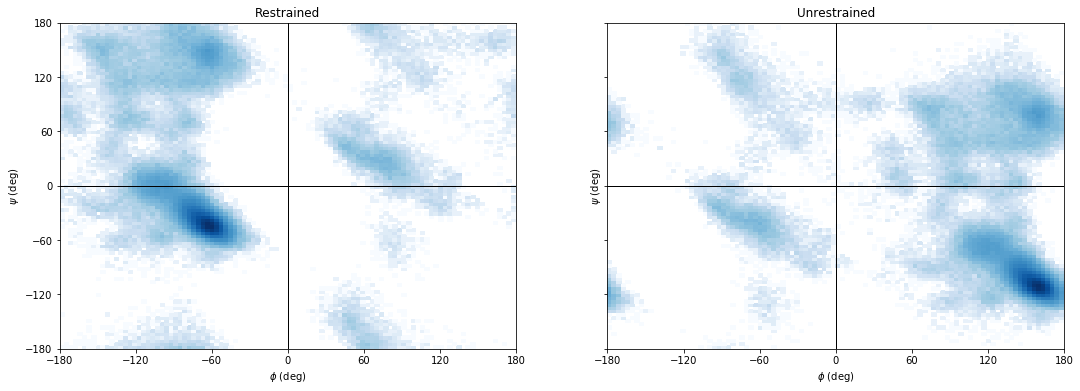

In [16]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')

# plot backbone dihedral maps for all frames
axes[0].hist2d(np.degrees(data[:,0]), np.degrees(data[:,1]), bins=100, 
               range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(np.degrees(A), np.degrees(B), bins=100, 
               range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

plt.show()

In [10]:
# dimensions
frames, torsions = 600, 856
# reshape angle arrays
xsss = np.hstack((A, B)).reshape(frames, torsions)

# calculate cos and sin 
# of phi, psi angles
pcos = np.cos(xsss)
psin = np.sin(xsss)
data = np.hstack((pcos, psin))

# standardize data
#scaler = StandardScaler()
#datset = scaler.fit_transform(data)

# get PCA projection 
pca = PCA(n_components=100)
vec = pca.fit_transform(data)

In [11]:
pca.explained_variance_ratio_
print(vec.shape)

(600, 100)


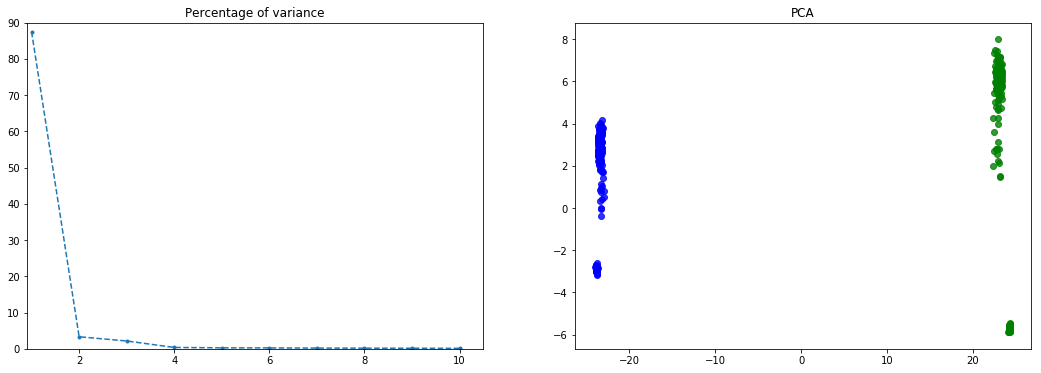

In [12]:
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.axis([0.9,10.5,0,90])
ax1.title.set_text('Percentage of variance')
#ax1.set(yticks=range(0, 21, 5), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax1.plot(range(1,11), pca.explained_variance_ratio_[:10]*100, marker='.', linestyle='dashed')

#ax2.axis([-15,15,-8,8])
ax2.title.set_text('PCA')
#ax2.set(xticks=range(-12, 13, 4), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax2.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
ax2.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')

In [54]:
class dPCAplus:
    '''Principal Component Analysis of dihedral angles
    
    Implementation of the dPCA+ method from references:
     
    J Comput Chem. 2009; 30(3):479-92. doi: 10.1002/jcc.21076.
    J Chem Phys. 2017; 147(24):244101. doi: 10.1063/1.4998259.
        
    with an Optimization step added to maximize shifting 
    1) the circular mean of the dihedral angles distribution 
    to the center of the space and 2) the maximal gap of the 
    sampling to the periodic boundary. 
    
    '''
    
    def __init__(self, angles):
        '''Initialize class
        
        Parameters
        ----------
        angles : float
            array of dihedral angles,
            angles.shape = (frames, dihedrals)
        
        '''
        self.ang = angles
        self.psi = self.ang[:,0]
        self.phi = self.ang[:,1]
        
    def cost(self, angles, gamma):
        '''Calculate cost function
        
        Parameters
        ----------
        angles : float
            numpy array of angles
        
        gamma : float 
            number between [0,1)
            
        Returns
        -------
        cost : float
            loss function
        
        '''
        c = self.dangle(self.stdmean(angles), 
                        self.cirmean(angles))
        d = self.dangle(self.lowdens(angles), -np.pi)
        return (gamma*c)**2 + d**2
    
    def step(self, theta, gamma, learnrate = 0.01):
        '''Calculate step using Gradient Descent
        
        Returns
        -------
        gamma : float
        
        '''
        # gradient
        gradd = 2 * gamma * theta**2
        # new step
        gamma -= learnrate * gradd
        # return new value
        return gamma
    
    def minimize(self, threshold = 0.001):
        '''Minimize
        
        '''
        # initialize gammas
        gs = random()
        gh = random()
        
        # objective function
        delta  = self.cost(self.psi, gs)
        delta += self.cost(self.phi, gh)
        
        # counter
        n = 0
        
        while abs(delta) > threshold:
            # break loop if too long
            if n > 100: break
            
            # increase counter
            n += 1
                
            # shift low density to boundary
            self.psi = self.swrap(self.psi, 
                                  self.lowdens(self.psi))
            self.phi = self.swrap(self.phi, 
                                  self.lowdens(self.phi))
            
            # calc rotation angles
            rs = self.dangle(self.stdmean(self.psi), 
                             self.cirmean(self.psi))
            rh = self.dangle(self.stdmean(self.phi), 
                             self.cirmean(self.phi))
            # calc new gammas
            gs = self.step(rs, gs)
            gh = self.step(rh, gh)
            # rotate maps
            self.psi = self.rotate(self.psi, rs*gs)
            self.phi = self.rotate(self.phi, rh*gh)
            
            # calc loss
            chi2  = self.cost(self.psi, gs)
            chi2 += self.cost(self.phi, gh)
            # rms change
            delta -= chi2
            
            # print evolution
            print("step %i change %.3f" % (n, abs(delta)))
            
        # Results
        rs = self.dangle(self.stdmean(self.psi), 
                         self.cirmean(self.psi))
        ds = self.dangle(self.lowdens(self.psi), -np.pi)
        print("Final for angle Psi:\n")
        print("      difference between means = %.2f\n" % rs) 
        print("      loss density at boundary = %.2f\n" % ds)
        rh = self.dangle(self.stdmean(self.phi), 
                         self.cirmean(self.phi))
        dh = self.dangle(self.lowdens(self.phi), -np.pi)
        print("Final for angle Phi:\n")
        print("      difference between means = %.2f\n" % rh) 
        print("      loss density at boundary = %.2f\n" % dh)
    
    def polar2rect(self, angles):
        '''Cartesian transformation
        
        Parameters
        ----------
        angles : float
            array of dihedral angles 
            in radians
        
        Returns
        -------
        array : float
            cosines and sines of angles
        
        '''
        c, s = np.cos(angles), np.sin(angles)
        return np.vstack((c,s))
    
    
    def lowdens(self, angles, width=5):
        '''Estimate lowest density angle
        
        Parameters
        ----------
        angles : float
            array of dihedral angles 
            in radians
        
        width : int
            binwidth of the density 
            distribution (default is 5)
            
        Returns
        -------
        angle : float
            angle bin of lowest density
        
        '''
        # define pi
        PI = np.pi
        # binwidth to radians
        bw = np.deg2rad(width)
        # calculate density
        dens, edges = np.histogram(angles, 
                                   bins=np.arange(-PI,PI,bw), 
                                   density=True)
        # get lowest density value 
        low = np.sort(dens, axis=None)[0]
        # index of lowest density
        idx = np.where(dens == low)
        # return first bin of lowest density
        return edges[idx][0]

    def cirmean(self, angles):
        '''Calculate circular mean
            
        Returns
        -------
        mean : float
            circular mean of angles
        
        '''
        # transformation
        c = np.average(np.cos(angles))
        s = np.average(np.sin(angles))
        # circular mean
        return atan2(s, c)
    
    def stdmean(self, angles):
        '''Compute average
        
        Returns
        -------
        mean : float
            standard mean of angles
        '''
        return np.average(angles)
    
    def swrap(self, angles, delta):
        '''Shift and wrap angles
        
        Parameters
        ----------
        delta : float
            value of the shift in radians
            
        Returns
        -------
        angles : float
            angles shifted by delta
            and wraped around -pi to pi
        '''
        circle = 2. * np.pi
        angles -= delta 
        angles %= circle
        return angles - np.pi
    
    def rotate(self, angles, theta):
        '''Rotate angles clockwise
        
        Parameters
        ----------
        theta : float
            rotation angle in radians
        
        Returns
        -------
        array : float
            angles rotate by theta around zero
        '''
        # rotation matrix
        c, s = np.cos(theta), np.sin(theta)
        r = np.array(((c,-s), (s, c)))
        # apply rotation
        x = self.polar2rect(angles)
        o = np.dot(r, x)
        # return new angles
        return np.arctan2(o[1,:], o[0,:])
    
    def dangle(self, x, y):
        '''minimum distance between 2 angles
         
        Parameters
        ----------
         
        x: float
           target torsion angle
        y: float 
           source torsion angle
        '''
        s = sin(x-y) 
        c = cos(x-y)
        return atan2(s,c)
#END

In [55]:
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# convert to radians
ress = np.deg2rad(r)
unre = np.deg2rad(u)

# combine datasets
data = np.vstack((ress,unre))
tmp = data

In [56]:
pippo = dPCAplus(tmp)

In [57]:
pippo.minimize()

step 1 change 11.738
step 2 change 11.310
step 3 change 10.996
step 4 change 10.782
step 5 change 10.546
step 6 change 10.235
step 7 change 9.810
step 8 change 9.660
step 9 change 9.290
step 10 change 9.149
step 11 change 8.911
step 12 change 8.421
step 13 change 8.275
step 14 change 7.909
step 15 change 7.771
step 16 change 7.544
step 17 change 7.127
step 18 change 6.983
step 19 change 6.621
step 20 change 6.487
step 21 change 6.194
step 22 change 5.940
step 23 change 5.641
step 24 change 5.441
step 25 change 5.265
step 26 change 4.946
step 27 change 4.817
step 28 change 4.407
step 29 change 4.271
step 30 change 4.038
step 31 change 3.752
step 32 change 3.626
step 33 change 3.433
step 34 change 3.081
step 35 change 2.949
step 36 change 2.719
step 37 change 2.437
step 38 change 2.315
step 39 change 2.125
step 40 change 1.777
step 41 change 1.610
step 42 change 1.422
step 43 change 1.258
step 44 change 1.071
step 45 change 0.794
step 46 change 0.516
step 47 change 0.392
step 48 change 0

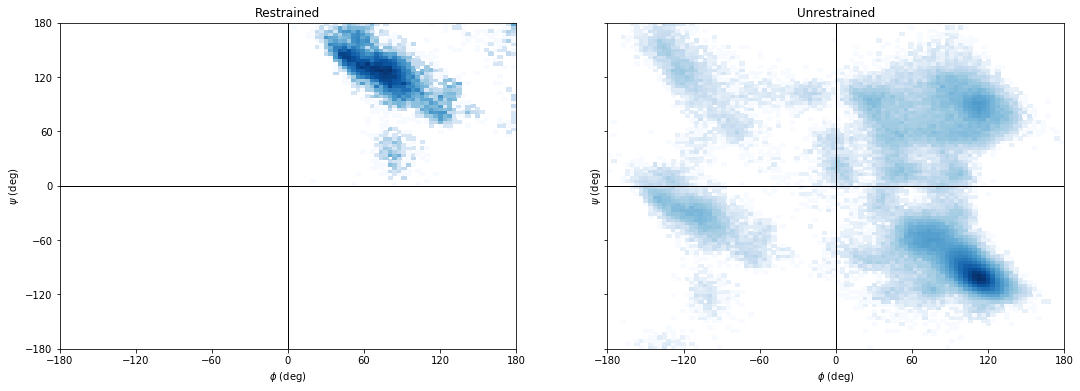

In [64]:
A = pippo.psi
B = pippo.phi
# create a figure and three subplots
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')

# plot backbone dihedral maps for all frames
axes[0].hist2d(np.degrees(data[:,0]), np.degrees(data[:,1]), bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(np.degrees(A), np.degrees(B), bins=100, 
               range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

plt.show()

In [32]:
##################################################################################################################

def dopca
        # dimensions
frames, torsions = 600, 856
# reshape angle arrays
xsss = np.hstack((A, B)).reshape(frames, torsions)

# calculate cos and sin 
# of phi, psi angles
pcos = np.cos(xsss)
psin = np.sin(xsss)
data = np.hstack((pcos, psin))

# standardize data
#scaler = StandardScaler()
#datset = scaler.fit_transform(data)

# get PCA projection 
pca = PCA(n_components=100)
vec = pca.fit_transform(data)


##################################################################################################################
 

SyntaxError: invalid syntax (<ipython-input-32-3129f84b8dc4>, line 3)

In [23]:
print(np.pi)

3.141592653589793


In [187]:
# select only calpha carbons
protein = trj.select_atoms("name CA")

# get cartesian positions for traj1 and 2
trajCA = np.array([protein.positions for ts in trj.trajectory])

NameError: name 'trj' is not defined

In [11]:
# scikit-learn expects 2d numpy arrays
# for the training dataset
frames, atoms, dimensions = trajCA.shape
# change dimensions
dataset = trajCA.reshape((frames,atoms*dimensions))

# get PCA projection 
pca = PCA(n_components=2)
vec = pca.fit(dataset).transform(dataset)

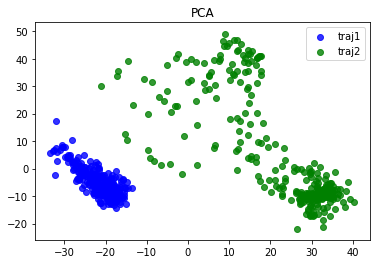

In [12]:
# plot
plt.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

In [13]:
kpca = KernelPCA(kernel="cosine", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dataset)

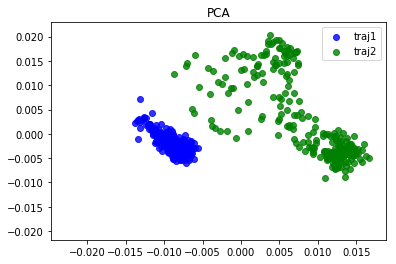

In [14]:
# plot
plt.scatter(X_kpca[:300,0], X_kpca[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(X_kpca[300:,0], X_kpca[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

In [ ]:
    def deg4rad(self, angles, degrees=True):
        '''Change angles units
        
        Parameters
        ----------
        angles : float
            array of dihedral angles
            
        degress : bool, optional 
            whether angles are in degress
            (default is True)
            
        Returns
        -------
        angles : float
            angles array in radians.
        
        '''
        # angles in degress
        if degrees:
            return np.deg2rad(angles)
        # otherwise do nothing
        else: pass